<a href="https://colab.research.google.com/github/erd3muysal/bone_fracture_classification/blob/main/bone_fracture_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive file system into Google Colab environments.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Moving into MURA data set directory path using Linux Bash commands and list the directory.

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/MURA-v1.1
!ls

/content/drive/My Drive/Colab Notebooks/MURA-v1.1
bone_fracture_classification.tflite  train_image_paths.csv
figures				     train_labeled_studies.csv
log				     valid
saved_models			     valid_image_paths.csv
train				     valid_labeled_studies.csv


Import necessary libraries and modules.

In [ ]:
import numpy as np  # Numerical calculations
import pandas as pd  # Data operations
import matplotlib.pyplot as plt  # Plotting operations
import seaborn as sns  # Visualization operations
import os  # Operating systems operations: file, directory etc.
import warnings
from numpy import random
from tqdm.notebook import tqdm  # Progress bar
import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as layers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import shuffle
from skimage.filters import threshold_local

In [ ]:
ROOT = '/content/drive/My Drive/Colab Notebooks/'  # Working directory path
BASE = ROOT + 'MURA-v1.1'  # MURA dataset directory path
TRAIN_DIR = ROOT + 'MURA-v1.1/train/XR_WRIST'  # Train data directory (only wrist radiographs)

SEED = 42
IMAGE_SIZE = (512, 512)
NUM_CHANNELS = 1
INITIAL_LEARNING_RATE = 0.0001
BATCH_SIZE = 8  # Experiment between 4 and 256
NUM_EPOCHS = 5  # Experiment between 50 and 250
NUM_FOLDS = 5  # K paramter for K-fold Cross Validation 
INPUT_SHAPE = (*IMAGE_SIZE, NUM_CHANNELS)

np.random.seed(SEED)

Define helper functions.

In [ ]:
def load_paths(root_path=TRAIN_DIR):
  '''
  Load image paths in the MURA dataset.

  args:
  root_path -- MURA dataset's path.

  returns:
  Paths -- List object that holds paths of all image files.
  Labels -- Numpy array object that holds labels of all image files.
  '''

  print("[BILGI] Resim dizin adresleri yükleniyor...")

  Paths = []  # List object for storing image paths
  Labels = []  # List object for storing image labels

  for root, dirs, files in tqdm(os.walk(root_path)):  # Read all image files via os.walk which returns and iterator generator that traverses all files
    for image_name in files:
      path = os.path.join(root, image_name)
      Paths.append(path)
      label = 1 if root.split('_')[-1] == 'positive' else 0   # Replace positive labels with one, and negative labels with zero
      Labels.append(label)

  print("[INFO] There are %d images in the dataset." % len(Paths))
  Paths = np.asarray(Paths)  # Convert to Numpy array
  Labels = np.asarray(Labels)  # Convert to Numpy array

  return Paths, Labels


def load_images(image_paths, size=IMAGE_SIZE, segmentation=False, configuration=None):
  '''
  Load images in the MURA dataset from their paths.

  args:
  image_paths -- Paths of image files.
  size -- Size of the image.

  returns:
  Images -- Numpy array object that holds pixel values of all image files.
  '''

  print("[INFO] Loading images...")
  Images = []  # List object for storing image data
  num_samples_succesfull = 0  # Number of images that succesfully loaded 
  num_samples_failed = 0  # Number of images that failed to load

  for image_path in tqdm(image_paths):
    try:
      img = load_img(image_path, color_mode='grayscale', target_size=IMAGE_SIZE)  # Load the image as graysclae and resize the image to be 512 x 512
      img = random_rotation_flip(img)  # Apply random rotation and flip operations
      if segmentation:  # If segmentation is true
        img = apply_segmentation(img, threshold=65)  # Apply segmentation
      img_arr = img_to_array(img)  # Convert image to a array
      Images.append(img_arr)
      num_samples_succesfull += 1  # Increase the number of images that succesfully loaded

    except Exception as e:  # If any expection occurs
      num_samples_failed += 1  # Increase the number of images that failed to load
      print("[Error][#%d] " % (num_samples_failed), image_path, str(e))  # Print the path of the image and error itself
      continue  

  print("[INFO] %d samples loaded succesfully, %d samples failed to load." % (num_samples_succesfull, num_samples_failed))
  Images = np.asarray(Images).astype('float32')  # Convert to Numpy array with float32 data type

  if configuration == 'pretrained':  # If the configuration is 'pretrained'
    Images = np.squeeze(Images, axis=-1)  # Remove last dimension of the image
    Images = np.repeat(Images[..., np.newaxis], 3, -1)  # Repeat current color channel for three times to make last dimension 3
    
  mean = np.mean(Images)  # Mean of the pixel values of images
  std = np.std(Images)  # Standart deviation of the pixel values of images
  Images = (Images - mean) / std  # Normalization

  """
  if K.image_data_format() == "channels_first":
    Images = np.expand_dims(Images, axis=1)  # Extended dimension 1

  if K.image_data_format() == "channels_last":
    Images = np.expand_dims(Images, axis=-1)  # Extended dimension 3(usebackend tensorflow:aixs=3; theano:axixs=1) 
  """

  return Images


def random_rotation_flip(image):
  '''
  Performs random flip and rotation operations on given image.

  args:
  image -- Image file to perform operations.
  
  returns:
  image -- Image file applied flip and rotation operations.
  '''

  flip_methods = ['PIL.Image.FLIP_LEFT_RIGHT',  
                  'PIL.Image.FLIP_TOP_BOTTOM']

  rotation_methods = ['PIL.Image.ROTATE_90',
                      'PIL.Image.ROTATE_180',
                      'PIL.Image.ROTATE_270',
                      'PIL.Image.TRANSPOSE',
                      'PIL.Image.TRANSVERSE']

  if random.randint(0, 1):  # Apply flip operation with %50 possibility
    flip_method = random.choice(flip_methods)  # Choose a random method
    image = im.transpose(method=flip_method)  # Apply choosed method

  if random.randint(0, 1):  # Apply rotation operation with %50 possibility
    rotation_method = random.choice(rotation_methods)  # Choose a random method
    image = im.transpose(method=rotation_method)  # Apply choosed method

  return image


def apply_segmentation(image, threshold):
  '''
  Performs segmentation operation on given image.

  args:
  image -- Image file to perform operations.
  threshold --  Threshold value.

  returns:
  binary_image_array -- Image file applied segmentation operation.
  '''
  
  # Loop over all pixel values in image,
  # set pixel value to 0 if it is greater than `threshold`
  # otherwise, set the pixel value to 1
  binary_image = image.point(lambda p: p > threshold and 255) 

  return binary_image


def show_image(image_path, report=True):
  '''
  Shows given image and reports details of it.

  args:
  image_path -- Path of image file to be showed.
  '''

  img = load_img(image_path[0], color_mode='grayscale')
  
  if report:  # If report is true
    # Print all image details
    print("Type of the image file: ", type(img))
    print("Format of the image file: ", img.format)
    print("Mode of the image file: ", img.mode)
    print("Size of the image file: ", img.size)

  plt.title("Label of the image: %d" %(image_path[1]))  # Show image label on title
  plt.imshow(img, cmap='gray')


def plot_image_slices(image_path, num_rows=4, num_columns=4, image_size=(8, 8)):
  '''
  Plot a montage of 16 (default) image slices.

  args:
  image_path -- Path of image file set to be showed.
  num_rows -- Number of rows.
  num_columns -- Number of columns.
  image_size -- Size of the image.
  '''

  w, h = image_size
  fig = plt.figure(figsize=(16, 16))

  for i in range(1, num_columns * num_rows + 1):
      fig.add_subplot(num_rows, num_columns, i)
      show_image(image_path[i], report=False)

In [ ]:
X_path, y = load_paths(root_path=TRAIN_DIR)  # Load image paths

[BILGI] Resim dizin adresleri yükleniyor...



[BILGI] Veri seti içerisinde 9790 resim bulunmaktadır.


In [ ]:
X_path, y = shuffle(X_path, y)  # Shuffle the image paths and labels together
X_path_and_y = list(zip(X_path, y))  # Zip the image paths and corresponding labels

In [ ]:
X_path[:50]  # Show first 50 record in image path list

array(['/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient06509/study1_positive/image2.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient06977/study1_positive/image1.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient07671/study1_negative/image2.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient07488/study1_negative/image1.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient07848/study1_negative/image1.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient07755/study1_negative/image1.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient08102/study1_negative/image2.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient06514/study1_positive/image1.png',
       '/content/drive/My Drive/Colab Notebooks/MURA-v1.1/train/XR_WRIST/patient

In [ ]:
y[:50]  # Show first 50 record in image labels list

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1])

In [ ]:
X_path = X_path[:1000]  # Ram problemi yaşamamak için sadece 1000 tanesini kullan
y = y[:1000]
X = load_images(X_path, IMAGE_SIZE, segmentation=False)  # Load images from image paths

[BILGI] Resimler yükleniyor...



[BILGI] 1000 örnek başarıyla yüklendi, 0 örnek yüklenemedi.


Resmin tipi:  <class 'PIL.PngImagePlugin.PngImageFile'>
Resmin formatı:  PNG
Resmin modu:  L
Resmin boyutu:  (288, 512)


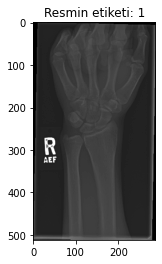

In [ ]:
show_image(X_path_and_y[0])

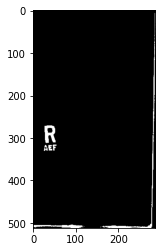

In [ ]:
img = load_img(X_path[0])
img = apply_segmentation(img, threshold=100)
plt.imshow(img)

Resmin tipi:  <class 'PIL.PngImagePlugin.PngImageFile'>
Resmin formatı:  PNG
Resmin modu:  L
Resmin boyutu:  (348, 512)


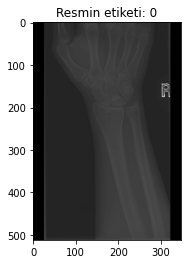

In [ ]:
show_image(X_path_and_y[50])

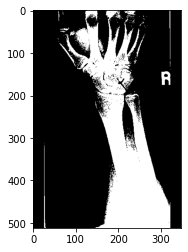

In [ ]:
img = load_img(X_path[50])
img = apply_segmentation(img, threshold=60)
plt.imshow(img)

Resmin tipi:  <class 'PIL.PngImagePlugin.PngImageFile'>
Resmin formatı:  PNG
Resmin modu:  L
Resmin boyutu:  (389, 512)


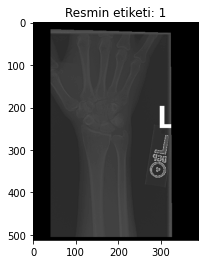

In [ ]:
show_image(X_path_and_y[100])

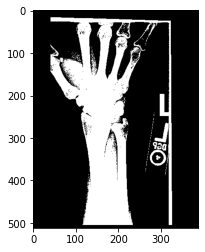

In [ ]:
img = load_img(X_path[100])
img = apply_segmentation(img, threshold=60)
plt.imshow(img)

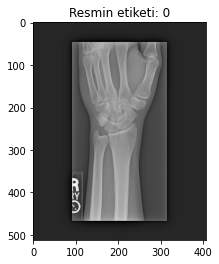

In [ ]:
show_image(X_path_and_y[150], report=False)

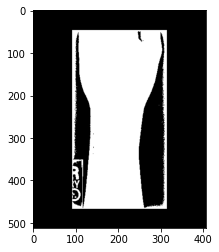

In [ ]:
img = load_img(X_path[150])
img = apply_segmentation(img, threshold=80)
plt.imshow(img)

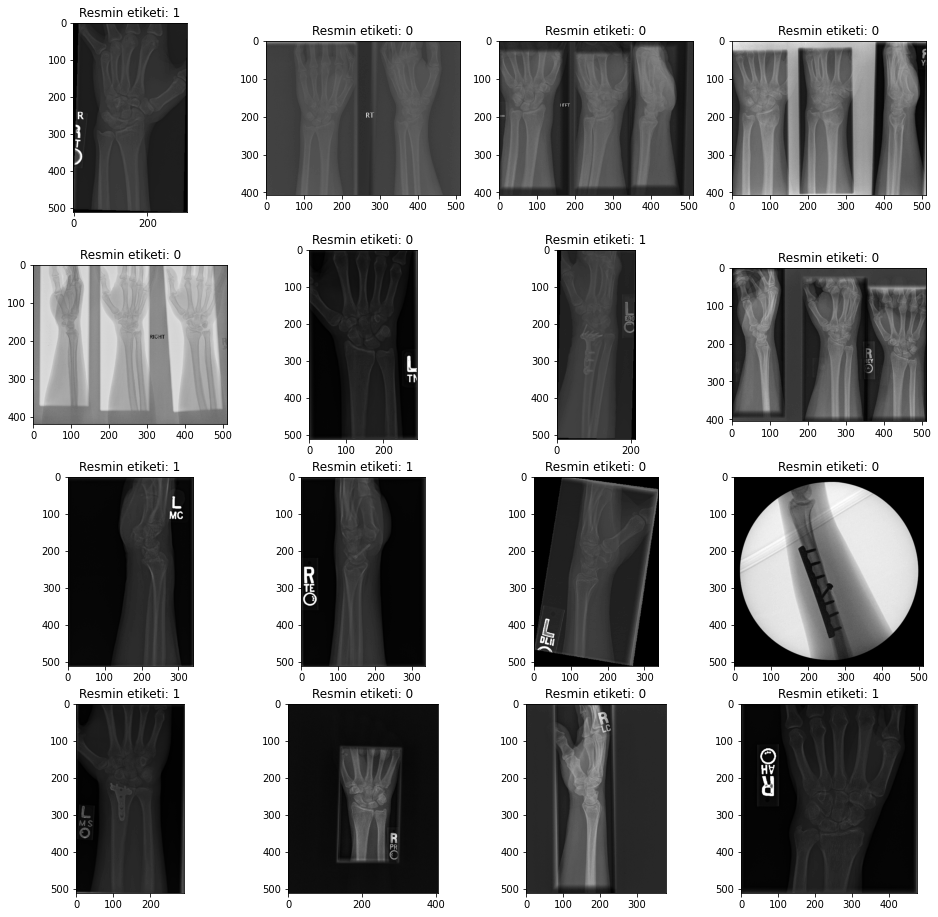

In [ ]:
plot_image_slices(X_path_and_y[:17]) 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)  # Create train and test sets by splitting dataset

In [ ]:
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train boyutu: (900, 512, 512, 1)
900 eğitim verisi
100 test verisi


In [ ]:
def build_ann_model():
  '''
  Build 4-layer artificial neural network model.
  '''

  inputs = keras.Input((512*512, 1))  # Input layer

  x = layers.Flatten()(inputs)  # (512, 512, 1) boyutunda olan resimleri (512x512, 1) = (262144, 1) haline getirir. Yapay sinir ağları için bu formatta olmalı girdiler.
  x = layers.Dense(units=64, activation='relu')(x)  # First hidden layer: 64 neuron + relu
  x = layers.Dense(units=32, activation='relu')(x)  # Second hidden layer: 32 neuron + relu
  x = layers.Dense(units=16, activation='relu')(x)  # Third hidden layer: 16 neuron + relu

  outputs = layers.Dense(units=1, activation='sigmoid')(x)  # Output layer: 1 neuron + sigmoid

  # Define the model.
  model = keras.Model(inputs=inputs, outputs=outputs, name='ann')

  return model

In [ ]:
# Build the model
model = build_ann_model()
# Show model summary
model.summary()

Model: "ann"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 262144, 1)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                16777280  
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 16,779,905
Trainable params: 16,779,905
Non-trainable params: 0
___________________________________________________

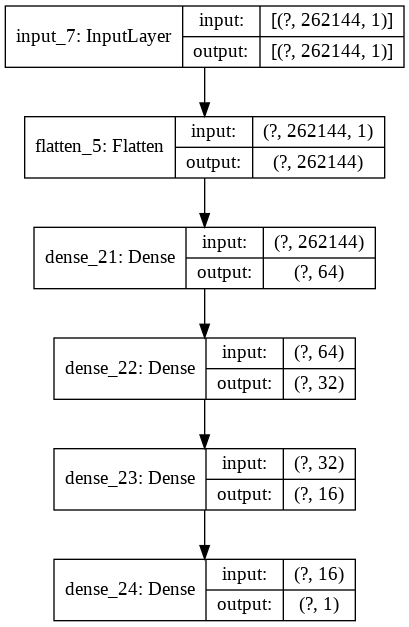

In [ ]:
# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Set learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    INITIAL_LEARNING_RATE, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile model
model.compile(
    loss='binary_crossentropy', # Use binary crossentropy loss function
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),  # Use Adam optimizer
    metrics=['acc'],  # Use accuracy metric
)

# Train the model, doing validation at the end of each epoch
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=25,
    validation_split=0.10,
    shuffle=True,
    verbose=1,
)

Epoch 1/25
26/26 [==============================] - 1s 20ms/step - loss: 1.7196 - acc: 0.5321 - val_loss: 1.4024 - val_acc: 0.5444
Epoch 2/25
26/26 [==============================] - 0s 15ms/step - loss: 1.4184 - acc: 0.6062 - val_loss: 1.2111 - val_acc: 0.4556
Epoch 3/25
26/26 [==============================] - 0s 15ms/step - loss: 1.5441 - acc: 0.7185 - val_loss: 1.7168 - val_acc: 0.5556
Epoch 4/25
26/26 [==============================] - 0s 16ms/step - loss: 1.2425 - acc: 0.7198 - val_loss: 1.2917 - val_acc: 0.5889
Epoch 5/25
26/26 [==============================] - 0s 15ms/step - loss: 0.7581 - acc: 0.7580 - val_loss: 2.0121 - val_acc: 0.5667
Epoch 6/25
26/26 [==============================] - 0s 15ms/step - loss: 0.8783 - acc: 0.7716 - val_loss: 1.2098 - val_acc: 0.6667
Epoch 7/25
26/26 [==============================] - 0s 15ms/step - loss: 0.8178 - acc: 0.7852 - val_loss: 1.1364 - val_acc: 0.6000
Epoch 8/25
26/26 [==============================] - 0s 15ms/step - loss: 0.4549 - a

In [ ]:
loss, score = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 6ms/step - loss: 2.4488 - acc: 0.5400


In [ ]:
def build_cnn_model():
  '''
  Build a 2D convolutional neural network model.

  returns:
  model -- Model.
  '''

  inputs = keras.Input(INPUT_SHAPE)

  x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(inputs)
  x = layers.MaxPool2D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool2D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool2D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool2D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)

  outputs = layers.Dense(units=1, activation='sigmoid')(x)

  # Define the model.
  model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

  return model


def inceptionV3_model():
  '''
  ImageNet veri seti ağırlıkları ile önceden eğitilmiş InceptionV3 modelini yükler.
  '''

  base_model = InceptionV3(input_shape=(512, 512, 3), weights='imagenet', include_top=False) # InceptionV3 modelini yükle ve son katmanı çıkar.

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(units=1024, activation='relu')(x)  # we add dense layers so that the model can learn more complex functions and classify for better results.
  x = Dense(units=1024, activation='relu')(x)  # dense layer 2
  x = Dense(units=512, activation='relu')(x)  # dense layer 3

  outputs = layers.Dense(units=1, activation='sigmoid')(x)  # final layer with softmax activation
  
  # Modeli tanımla
  model = Model(inputs=base_model.input, outputs=outputs, name='InceptionV3')

  return model


def monitor_model(history, save=False):
  '''
  Model metriklerini ve bilgilerini görüntüler.
  '''

  figures_dir = os.path.join(os.getcwd(), 'figures/')
  if not os.path.isdir(figures_dir):
    os.makedirs(figures_dir)

  with open(os.path.join(os.getcwd(), 'log/training.log'), 'r') as f:
    log = f.read()

  fig, ax = plt.subplots(1, 2, figsize=(20, 3))
  ax = ax.ravel()

  for i, metric in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    ax[i].grid(True)

    if save:
      fig.savefig(figures_dir + metric + '_plot.jpg')

  plt.show()
  plt.clf()
  plt.close()


def plot_confusion_matrix(y_test, y_pred):
  '''  
  Plots confusion matrix.
  '''  

  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
  plt.xlabel('Actual Label')
  plt.ylabel('Predicted Label')

In [ ]:
# Modeli oluştur
model = build_cnn_model()
# Model özetini görüntüle
model.summary()

In [ ]:
# Define callbacks

# Create a directory for saving model's checkpoint
checkpoint_dir = os.path.join(os.getcwd(), 'saved_models/')
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Save model with highest `val_acc`
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    checkpoint_dir + 'model.{epoch:02d}-{val_acc:.2f}.h5', save_best_only=True
)

# Stop trainin process if `val_acc` decreases for `patiance` times
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=15
)

# Create a directory for saving model's log data
csv_loggger_dir = os.path.join(os.getcwd(), 'log/')
if not os.path.isdir(csv_loggger_dir):
    os.makedirs(csv_loggger_dir)

# Write model log data to a file
csv_logger_cb = keras.callbacks.CSVLogger(csv_loggger_dir + 'training.log')

# Öğrenme kat sayısı kat sayısı düzenleyici tanımla
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Öğrenme kat sayısı programlayıcısını tanımla
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    INITIAL_LEARNING_RATE, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc'],
)

# Train the model, doing validation at the end of each epoch
history = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.10,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb, csv_logger_cb, reduce_lr_cb],
)

In [ ]:
loss, score = model.evaluate(x=X_test, y=y_test)  # Test model on test set

In [ ]:
y_pred = model.predict(X_test, batch_size=None, verbose=0, steps=None)

for i in range(0, len(y_pred)):
  if y_pred[i] > 0.5 :
    print(X_path[i],":\t","Positive\t", y_pred[i])
  else:
    print(X_path[i],":\t","Negative\t", y_pred[i])

#y_pred[y_pred > 0.5] = 1.
#y_pred[y_pred <= 0.5] = 0.

In [ ]:
monitor_model(history=history, save=True)

In [ ]:
def train_KFoldCV():
  '''
  Build a 2D convolutional neural network model with K-Fold cross validation technique.
  '''

  # Define 5-fold cross validation test harness
  kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
  cv_losses = []
  cv_accs = []

  for train, test in kfold.split(X, y):
    # Create model
    model = build_model(input_shape=INPUT_SHAPE)
    history = train(model)
    
    # Evaluate the model
    loss, score = model.evaluate(x=X[test], y=y[test])
    print("%s: %.2f%%" % (model.metrics_names[1], score * 100))
    cv_losses.append(loss)  
    cv_accs.append(score * 100)
  
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  
  return history

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('bone_fracture_classification.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('bone_fracture_classification.tflite')

print('`bone_fracture_classification.tflite` has been downloaded')